* [1.Load Data From CSV File](#ld)
* [2.Build a pipeline](#bp)
* [3.Idée pour choisir le meilleur modèle](#ic)
* [4.Modèles de machine learning choisis](#mml)


In [36]:
#!pip install xgboost

In [37]:
#!pip install lightgbm 

In [38]:
#!pip install joblib

In [97]:
import pandas as pd
import numpy as np

import missingno as msno
import seaborn as sns

import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['axes.grid'] = True
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder,StandardScaler

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from  xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
import shap

import sklearn

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score,StratifiedGroupKFold
from sklearn.metrics import mean_absolute_error,r2_score
from time import time
from julearn import run_cross_validation
from julearn.utils import configure_logging
from julearn.model_selection import StratifiedGroupsKFold
from statistics import mean

from sklearn.metrics import mean_squared_error


In [40]:
############Fonction affichant les variables corrélés en fixant un seuil
def f_strong_correlation(threshold_up ,df2):
    #threshold_up = 0.7
    corr_pairs = df2.corr().unstack().sort_values(kind="quicksort")
    strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold_up)])
               .reset_index().rename(columns={0:'corr_coeff'}))
    strong_corr = strong_corr[(strong_corr.index%2 == 0) & 
                          (strong_corr['level_0'] != strong_corr['level_1'])]
    strong_corr.sort_values('corr_coeff', ascending=False)
    return strong_corr
##################"fonction pour afficher les performances d'un modèle
def f_performance(pip):
    #pip.fit(X_train,y_train)
  
    
    print('******************')
    #Check MSE and RMSE

    y_pred = pip.predict(X_test)
    print(f'MSE : {mean_squared_error(y_test, y_pred):.3f}')
    print(f'RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')
    print(f'R2 : {r2_score(y_test, y_pred):.3f}')
##################################################
def f_coeff(pip):
    # Putting together the coefficient and their corresponding variable names
    
    df_coefficient = pd.DataFrame()
    df_coefficient["Columns"] = feature_after_transformer(preprocessor)
    df_coefficient['Estimated Coefficient '] = pd.Series(pip.named_steps['model'].coef_.flatten())
    return df_coefficient
    #print(lreg_coefficient)
####################""
def feature_after_transformer(preprocessor):
    tx = preprocessor.get_params()['transformers']
    feature_names = []
    for name,transformer,features in tx:
        try:
            Var = preprocessor.named_transformers_[name].get_feature_names_out().tolist()
        except AttributeError:
            Var = features
        feature_names = feature_names + Var

    return feature_names
#####fonction pour sauvegarder le modele/gridsearch
def save_model_grid(object_to_save,filename,object_type):
    if object_type=='model':
        ch=filename+'.joblib'
    elif object_type=='gridsearch':
        ch=filename+'.pkl'
    joblib.dump(object_to_save,ch)

#####fonction pour charger le modele/gridsearch
def load_model_grid(ch):
    loaded_object = joblib.load(ch)
    return loaded_model
########fonction pour extraire les données d'un pipeline apres pretraitement
def preprocessed_data(X,pip):
    X_encoded = pip['preprocessor'].fit_transform(X)
    return X_encoded


### 1.Load Data From CSV File<a class="anchor" id="ld"></a>

In [41]:
#df = pd.read_csv('prepared_data.csv', sep='\t')

df = pd.read_csv('df_quantile.csv',sep='\t')



In [42]:
df

,OSEBuildingID,%NaturalGas(kBtu),%SteamUse(kBtu),BuildingType,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,tranche_date,BuildingAge,groups_neighborhood,groups_PrimaryPropertyType,GFABuildingRate
0,1,-0.102156,1.780760,NonResidential,-5.199338,1.579469,0.526416,-0.698331,0.468375,0.686155,1.063067,1.032726,tranche_date1,89,Various,Various,5.199338
1,2,1.124928,-5.199338,NonResidential,-5.199338,1.513075,0.672627,-0.676067,0.404029,0.785512,1.186095,1.038121,tranche_date3,20,Various,Various,-0.891433
2,3,-0.449644,1.811514,NonResidential,-5.199338,2.391518,2.294560,-1.018128,0.872260,2.764908,2.956706,0.798036,tranche_date2,47,Various,Various,-1.024762
3,5,0.078370,1.850416,NonResidential,-5.199338,1.431438,0.257700,-0.794587,0.711613,0.648032,1.153135,1.474777,tranche_date1,90,Various,Various,5.199338
4,8,1.164911,-5.199338,NonResidential,-5.199338,1.811195,1.046169,0.551688,0.682473,1.145998,1.599488,1.042423,tranche_date3,36,Various,Various,-1.432289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1536,50221,0.200061,-5.199338,Nonresidential COS,-5.199338,-5.199338,-2.511288,-0.138583,-0.113266,-0.956453,-0.664672,0.179283,tranche_date3,34,Various,Various,5.199338
1537,50223,1.000820,-5.199338,Nonresidential COS,-5.199338,-5.199338,-2.654090,-0.138583,-0.261901,-0.937300,-0.346737,0.717694,tranche_date4,12,Various,Various,5.199338
1538,50224,1.415149,-5.199338,Nonresidential COS,-5.199338,-5.199338,-2.844696,-0.138583,2.205546,0.542936,0.985572,2.901564,tranche_date2,42,Various,Various,5.199338
1539,50225,0.776000,-5.199338,Nonresidential COS,-5.199338,-5.199338,-2.769757,-0.138583,-0.383428,-1.226110,-0.615832,0.505473,tranche_date3,27,Various,Various,5.199338


In [43]:
df.shape

(1541, 17)

In [44]:
columns=list(df.columns)
columns

['OSEBuildingID',
 '%NaturalGas(kBtu)',
 '%SteamUse(kBtu)',
 'BuildingType',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'ENERGYSTARScore',
 'SourceEUI(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'tranche_date',
 'BuildingAge',
 'groups_neighborhood',
 'groups_PrimaryPropertyType',
 'GFABuildingRate']

In [45]:
target1='TotalGHGEmissions'
target2='SiteEnergyUse(kBtu)'

In [46]:
f_strong_correlation(0.7 ,df)

,level_0,level_1,corr_coeff
0,PropertyGFATotal,SiteEnergyUse(kBtu),0.716380
2,SiteEnergyUse(kBtu),SourceEUI(kBtu/sf),0.732017
4,TotalGHGEmissions,GHGEmissionsIntensity,0.756458
6,SiteEnergyUse(kBtu),TotalGHGEmissions,0.885268


In [47]:
#ici on élimine 'OSEBuildingID' et ''TotalGHGEmissions''(target1)
cols=list(set(columns)-set(['OSEBuildingID','PropertyGFATotal','SourceEUI(kBtu/sf)',target1]))
cols

['%SteamUse(kBtu)',
 '%NaturalGas(kBtu)',
 'GHGEmissionsIntensity',
 'SiteEnergyUse(kBtu)',
 'NumberofBuildings',
 'BuildingAge',
 'GFABuildingRate',
 'BuildingType',
 'tranche_date',
 'groups_PrimaryPropertyType',
 'NumberofFloors',
 'ENERGYSTARScore',
 'groups_neighborhood']

In [48]:
df=df[cols]

In [49]:
numercial_cols = [col for col in df.columns if df[col].dtype!="O"]
print(numercial_cols)

['%SteamUse(kBtu)', '%NaturalGas(kBtu)', 'GHGEmissionsIntensity', 'SiteEnergyUse(kBtu)', 'NumberofBuildings', 'BuildingAge', 'GFABuildingRate', 'NumberofFloors', 'ENERGYSTARScore']


In [50]:
categorical_cols = [col for col in df.columns if df[col].dtype=="O"]
print(categorical_cols)

['BuildingType', 'tranche_date', 'groups_PrimaryPropertyType', 'groups_neighborhood']


In [51]:
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus'], dtype=object)

In [52]:
df['groups_neighborhood'].unique()

array(['Various', 'North', 'Central', 'South'], dtype=object)

In [53]:
df['tranche_date'].unique()

array(['tranche_date1', 'tranche_date3', 'tranche_date2', 'tranche_date4'],
      dtype=object)

In [54]:
df['groups_PrimaryPropertyType'].unique()

array(['Various', 'Commerce', 'Health'], dtype=object)

In [55]:
df.shape

(1541, 13)

In [56]:
numercial_cols_for_transformer=list(set(numercial_cols)-set([target2]))

In [57]:
numercial_cols_for_transformer

['%SteamUse(kBtu)',
 '%NaturalGas(kBtu)',
 'GHGEmissionsIntensity',
 'NumberofBuildings',
 'BuildingAge',
 'GFABuildingRate',
 'NumberofFloors',
 'ENERGYSTARScore']

## 2.Build a pipeline <a class="anchor" id="bp"></a>

In [58]:
# Create pipelines for numerical and categorical features
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore",drop='first')
 #when using sklearn.compose.ColumnTransformer You need to make sure the output column is not included in the data you create your Preprocessing pipeline with
# Create ColumnTransformer to apply pipeline for each column type
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numercial_cols_for_transformer),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [59]:
feature_after_transformer(preprocessor)

['%SteamUse(kBtu)',
 '%NaturalGas(kBtu)',
 'GHGEmissionsIntensity',
 'NumberofBuildings',
 'BuildingAge',
 'GFABuildingRate',
 'NumberofFloors',
 'ENERGYSTARScore',
 'BuildingType',
 'tranche_date',
 'groups_PrimaryPropertyType',
 'groups_neighborhood']

In [60]:
y=df[[target2]]
y= StandardScaler().fit_transform(y)
features=list(set(cols)-set([target2]))
X=df[features]

#### Continuous target stratification

In [61]:
import math
num_splits = 10

num_bins = math.floor(len(df) / num_splits)  # num of bins to be created


bins_on = y  # variable to be used for stratification
bins_on
qc = pd.cut(bins_on.flatten(), num_bins)  # divides data in bins
df['bins'] = qc.codes
groups = 'bins'
y_binned=df['bins']



In [62]:
num_bins

154

In [63]:
df2 = df[df['bins'].isin(df['bins'].value_counts()[df['bins'].value_counts()>2].index)]

In [64]:
df2.loc[:,'bins'].value_counts()

74     42
77     42
76     41
79     41
75     41
       ..
108     4
46      3
110     3
112     3
111     3
Name: bins, Length: 70, dtype: int64

In [65]:
df.shape #(1541, 14)


(1541, 14)

In [66]:
df2.shape#(1516, 14)

(1516, 14)

In [67]:
y2_binned=df2['bins']
X2=df2[features]
y2=df2[target2]

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, stratify=y2_binned,random_state=0)

## 3.Idée pour choisir le meilleur modèle <a class="anchor" id="ic"></a>

In [69]:
regressors = [DummyRegressor(strategy="mean",constant=None,quantile=0.5),
              LinearRegression(fit_intercept=True,normalize=True,copy_X=True),
              Ridge(alpha=5,solver='auto',fit_intercept=True),
              Lasso(tol=1e-3,selection='random',fit_intercept=True),
              ElasticNet(tol=1e-3,selection='random',fit_intercept=True),
              RandomForestRegressor(n_estimators=300,max_leaf_nodes=1000,criterion='squared_error'),
              SVR(kernel='rbf',degree=3,gamma='scale'),
              LGBMRegressor(boosting_type='gbdt',num_leaves=31,max_depth=1),
              XGBRegressor(objective ='reg:squarederror',booster="dart",
                  n_estimators = 300)
              ]

In [70]:
test_mse=[]
test_rmse=[]
test_r2=[]
train_r2=[]
models=[]
for model in regressors:
    start = time()
    #select=SelectKBest(score_func=f_regression,k=8)
    #pip = Pipeline(steps=[("preprocessor", preprocessor),("selector",select),("model", model)])
    pip = Pipeline(steps=[("preprocessor", preprocessor),("model", model)])
    models.append(model)
    pip.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = pip.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    scores = cross_val_score(pip, X_train, y_train, cv=10,scoring='r2')
    print("\tTest Mean squared error:", mean_squared_error(y_test, y_pred))
    test_mse.append(mean_squared_error(y_test, y_pred))
    print("\tTest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    test_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    print("\tTest R2 score:", r2_score(y_test, y_pred))
    test_r2.append(r2_score(y_test, y_pred))
    print("\tTraining R2 score (Cross validation):", mean(scores))
    adj_r2 = (1 - (1 - r2_score(y_test, y_pred)) * ((X_train.shape[0] - 1) / 
          (X_train.shape[0] - X_train.shape[1] - 1)))
    print("\tTraining adjusted R2 score :", adj_r2)
    train_r2.append(mean(scores))
    print()


DummyRegressor(quantile=0.5)
	Training time: 0.593s
	Prediction time: 0.020s
	Test Mean squared error: 0.9140754384339492
	Test RMSE: 0.9560729252697983
	Test R2 score: -2.727026014293088e-05
	Training R2 score (Cross validation): -0.018328718911030828
	Training adjusted R2 score : -0.010035883473755725

LinearRegression(normalize=True)
	Training time: 1.707s
	Prediction time: 0.022s
	Test Mean squared error: 0.5046089983220425
	Test RMSE: 0.7103583590850765
	Test R2 score: 0.44794188977963545
	Training R2 score (Cross validation): 0.5146051950663405
	Training adjusted R2 score : 0.4424167043562457

Ridge(alpha=5)
	Training time: 0.488s
	Prediction time: 0.016s
	Test Mean squared error: 0.5020948756466947
	Test RMSE: 0.7085865336334686
	Test R2 score: 0.45069241903620816
	Training R2 score (Cross validation): 0.5160408723030111
	Training adjusted R2 score : 0.44519476184557805

Lasso(selection='random', tol=0.001)
	Training time: 0.078s
	Prediction time: 0.031s
	Test Mean squared error

In [71]:
d={'Regressor':models,'Test Mean squared error':test_mse,'Test RMSE':test_rmse,'Test R2 score':test_r2,
  'Training R2 score (Cross validation)':train_r2}
pd.DataFrame(d)

,Regressor,Test Mean squared error,Test RMSE,Test R2 score,Training R2 score (Cross validation)
0,DummyRegressor(quantile=0.5),0.914075,0.956073,-0.000027,-0.018329
1,LinearRegression(normalize=True),0.504609,0.710358,0.447942,0.514605
2,Ridge(alpha=5),0.502095,0.708587,0.450692,0.516041
3,"Lasso(selection='random', tol=0.001)",0.914075,0.956073,-0.000027,-0.018329
4,"ElasticNet(selection='random', tol=0.001)",0.914075,0.956073,-0.000027,-0.018329
5,"(DecisionTreeRegressor(max_features='auto', ma...",0.294065,0.542277,0.678284,0.701368
6,SVR(),0.344991,0.587359,0.622569,0.659445
7,LGBMRegressor(max_depth=1),0.353755,0.594773,0.612980,0.609223
8,"XGBRegressor(base_score=0.5, booster='dart', c...",0.274405,0.523837,0.699792,0.681968


**Note**
<br>
Dans la suite en se basant sur le coefficient de détermination (R2 score), on va travailler sur RandmForestRgressor et XGBRegressor.

## 4.Modèles de machine learning choisis<a class="anchor" id="mml"></a>

In [72]:
def f_performance(pip):
    #pip.fit(X_train,y_train)
  
    
    print('******************')
    #Check MSE and RMSE

    y_pred = pip.predict(X_test)
    print(f'MSE : {mean_squared_error(y_test, y_pred):.3f}')
    print(f'RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')
    print(f'R2 : {r2_score(y_test, y_pred):.3f}')

In [73]:
font = {
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

##### 

## 4.1.RandomForestRegressor

In [74]:
clf_rf = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", RandomForestRegressor(n_estimators=300,max_leaf_nodes=1000,criterion='squared_error'))]
)
clf_rf.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['%SteamUse(kBtu)',
                                                   '%NaturalGas(kBtu)',
                                                   'GHGEmissionsIntensity',
                                                   'NumberofBuildings',
                                                   'BuildingAge',
                                                   'GFABuildingRate',
                                                   'NumberofFloors',
                                                   'ENERGYSTARScore']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                           

In [75]:
f_performance(clf_rf)

******************
MSE : 0.296
RMSE : 0.544
R2 : 0.677


<BarContainer object of 19 artists>

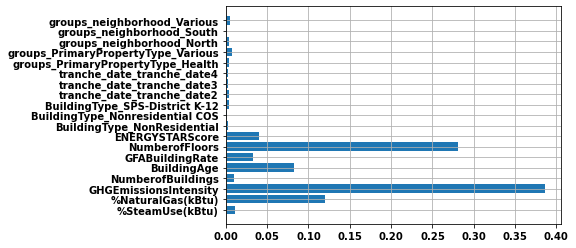

In [98]:
plt.barh(feature_after_transformer(preprocessor), clf_rf['model'].feature_importances_)

**Observations:**
<br>
Les variables les plus importantes sont:'GHGEmissionsIntensity', 'NumberofFloors','%NaturalGas(kBtu)'et 'BuildingAge.

list

### 4.5.2.Optimisation du modèle

In [77]:
list(clf_rf.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessor',
 'model',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__verbose_feature_names_out',
 'preprocessor__num',
 'preprocessor__cat',
 'preprocessor__num__memory',
 'preprocessor__num__steps',
 'preprocessor__num__verbose',
 'preprocessor__num__scaler',
 'preprocessor__num__scaler__copy',
 'preprocessor__num__scaler__with_mean',
 'preprocessor__num__scaler__with_std',
 'preprocessor__cat__categories',
 'preprocessor__cat__drop',
 'preprocessor__cat__dtype',
 'preprocessor__cat__handle_unknown',
 'preprocessor__cat__sparse',
 'model__bootstrap',
 'model__ccp_alpha',
 'model__criterion',
 'model__max_depth',
 'model__max_features',
 'model__max_leaf_nodes',
 'model__max_samples',
 'model__min_impurity_decrease',
 'model__min_samples_leaf',
 'model__min_samples_split',
 'model__min_weight_fracti

In [78]:
param_grid = {
    
    #"model__max_leaf_nodes": [1000,5000,100000,None],
    "model__n_estimators": [1000,500,100],
     "model__criterion": ['squared_error', 'absolute_error', 'poisson']
    
}
grid_search_rf = GridSearchCV(clf_rf, param_grid, cv=10)
grid_search_rf.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['%SteamUse(kBtu)',
                                                                          '%NaturalGas(kBtu)',
                                                                          'GHGEmissionsIntensity',
                                                                          'NumberofBuildings',
                                                                          'BuildingAge',
                                                                          'GFABuildingRate',
                                                                     

In [79]:
cv_results = pd.DataFrame(grid_search_rf.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,8.844669,0.732638,0.182778,0.027314,squared_error,1000,"{'model__criterion': 'squared_error', 'model__...",0.624181,0.661748,0.647488,0.751870,0.774969,0.582745,0.746415,0.736967,0.774253,0.733326,0.703396,0.064853,4
1,4.146202,0.332278,0.095134,0.015842,squared_error,500,"{'model__criterion': 'squared_error', 'model__...",0.622905,0.661980,0.642846,0.753902,0.774774,0.582769,0.748038,0.736781,0.772836,0.734030,0.703086,0.065516,5
2,0.790881,0.032052,0.026582,0.010013,squared_error,100,"{'model__criterion': 'squared_error', 'model__...",0.608277,0.654883,0.649451,0.751526,0.774438,0.574936,0.752608,0.734508,0.775917,0.724952,0.700149,0.068691,6
3,68.922592,2.001157,0.178627,0.013059,absolute_error,1000,"{'model__criterion': 'absolute_error', 'model_...",0.632347,0.662965,0.651835,0.753200,0.771413,0.585318,0.752070,0.734678,0.779210,0.741946,0.706498,0.063934,2
4,33.568101,0.433016,0.093479,0.008229,absolute_error,500,"{'model__criterion': 'absolute_error', 'model_...",0.643312,0.668268,0.648941,0.752984,0.772623,0.583689,0.749809,0.737616,0.779016,0.737514,0.707377,0.062801,1
5,6.674011,0.140352,0.023441,0.007811,absolute_error,100,"{'model__criterion': 'absolute_error', 'model_...",0.631866,0.655629,0.650431,0.750535,0.775101,0.580640,0.747583,0.734516,0.777971,0.742358,0.704663,0.065284,3
6,0.018741,0.009353,0.000000,0.000000,poisson,1000,"{'model__criterion': 'poisson', 'model__n_esti...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
7,0.014061,0.004687,0.000000,0.000000,poisson,500,"{'model__criterion': 'poisson', 'model__n_esti...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
8,0.012499,0.006250,0.000000,0.000000,poisson,100,"{'model__criterion': 'poisson', 'model__n_esti...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9


In [80]:
grid_search_rf.best_params_

{'model__criterion': 'absolute_error', 'model__n_estimators': 500}

In [81]:
best_estim_rf=grid_search_rf.best_estimator_
f_performance(best_estim_rf)

******************
MSE : 0.295
RMSE : 0.543
R2 : 0.677


<BarContainer object of 19 artists>

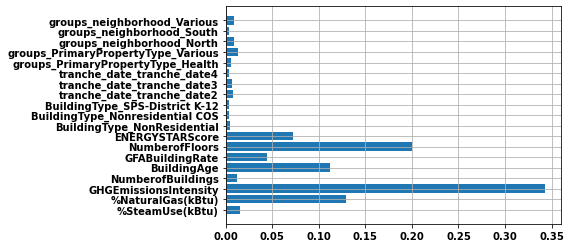

In [101]:
plt.barh(feature_after_transformer(preprocessor), best_estim_rf['model'].feature_importances_)

In [83]:
save_model_grid(grid_search_rf,'grid_search_rf_target2','gridsearch')
save_model_grid(best_estim_rf,'best_rf_target2','model')

## 4.6.XGBRegressor

In [84]:
clf_xg = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123))]
)
clf_xg.fit(X_train,y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['%SteamUse(kBtu)',
                                                   '%NaturalGas(kBtu)',
                                                   'GHGEmissionsIntensity',
                                                   'NumberofBuildings',
                                                   'BuildingAge',
                                                   'GFABuildingRate',
                                                   'NumberofFloors',
                                                   'ENERGYSTARScore']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                           

In [85]:
f_performance(clf_xg)

******************
MSE : 0.293
RMSE : 0.541
R2 : 0.680


### 4.6.2.Optimisation du modèle

In [86]:
#list(clf_xg.get_params().keys())

In [87]:
param_grid = {
    
    "model__booster": ['squarederror','gbtree'],
    "model__n_estimators": [1500,1000],
    
    #"model__max_leaves": [10000, 1500,1000,100],
    "model__learning_rate": [0.3, 0.5,0.1,0.01,0.001]
    
}


grid_search_xg = GridSearchCV(clf_xg, param_grid, cv=10)
grid_search_xg.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['%SteamUse(kBtu)',
                                                                          '%NaturalGas(kBtu)',
                                                                          'GHGEmissionsIntensity',
                                                                          'NumberofBuildings',
                                                                          'BuildingAge',
                                                                          'GFABuildingRate',
                                                                     

In [88]:
cv_results = pd.DataFrame(grid_search_xg.cv_results_)
cv_results
grid_search_xg.best_params_
cv_results.to_csv('cvresults_xg_target2.csv')

In [102]:
grid_search_xg.best_params_

{'model__booster': 'gbtree',
 'model__learning_rate': 0.01,
 'model__n_estimators': 1000}

In [89]:
best_estim_xg=grid_search_xg.best_estimator_
f_performance(best_estim_xg)

******************
MSE : 0.263
RMSE : 0.513
R2 : 0.712


In [90]:
save_model_grid(grid_search_xg,'grid_search_XG_target2','gridsearch')
save_model_grid(best_estim_xg,'best_xg_target2','model')

In [94]:
# fit the preprocessor 
X_encoded = grid_search_xg.best_estimator_['preprocessor'].fit_transform(X_train)

# fit the model 
best_model = grid_search_xg.best_estimator_['model'].fit(X_encoded, y_train)

# calculate the Shap values
shap_values = shap.TreeExplainer(best_model).shap_values(X_encoded)

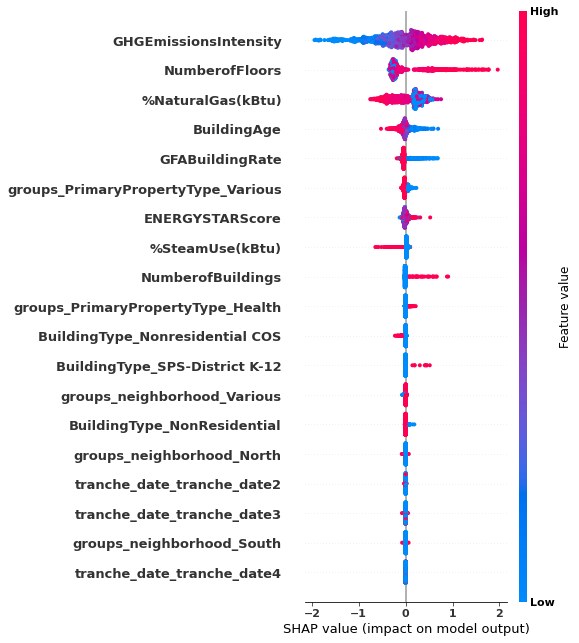

In [95]:
shap.summary_plot(shap_values, X_encoded,feature_names=feature_after_transformer(preprocessor))

**Observations**
<br>
Ce  graphique globale  montre les valeurs de Shap sur l'axe des x. Ici, toutes les valeurs à gauche représentent les observations qui déplacent la valeur prédite dans la direction négative, tandis que les points à droite contribuent à déplacer la prédiction dans une direction positive. 
<br>
L'axe y contient les variables

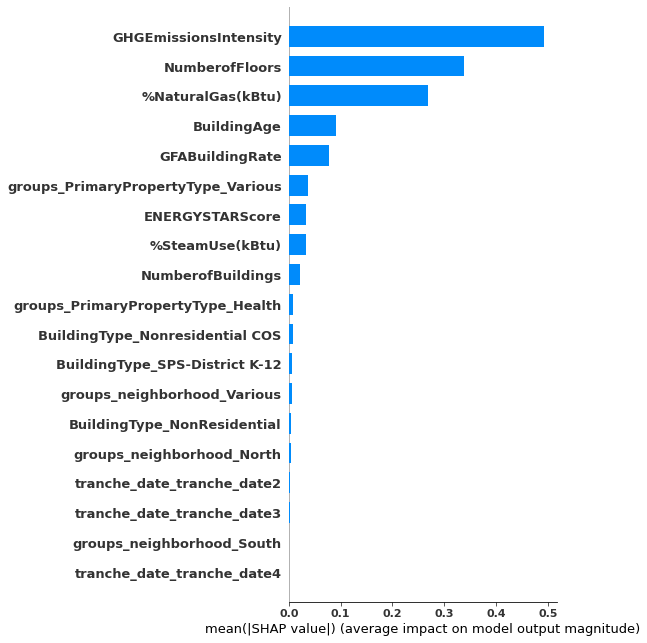

In [96]:
# plot the Shap values
shap.summary_plot(shap_values, X_encoded, plot_type='bar',feature_names=feature_after_transformer(preprocessor))

In [ ]:
#shap.dependence_plot("GHGEmissionsIntensity",shap_values,X_encoded)

# Impact  de la variable energy star score

In [103]:




X_train_without_energyscore=X_train.drop(['ENERGYSTARScore'], axis=1)
X_test_without_energyscore=X_test.drop(['ENERGYSTARScore'], axis=1)

numercial_cols_for_transformer2=list(set(numercial_cols_for_transformer)-set(['ENERGYSTARScore']))
preprocessor2 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numercial_cols_for_transformer2),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

numercial_cols_for_transformer2

test2_mse=[]
test2_rmse=[]
test2_r2=[]
train2_r2=[]
for model in regressors:
    start = time()
    #select=SelectKBest(score_func=f_regression,k=8)
    #pip = Pipeline(steps=[("preprocessor", preprocessor),("selector",select),("model", model)])
    pip = Pipeline(steps=[("preprocessor", preprocessor2),("model", model)])

    pip.fit(X_train_without_energyscore, y_train)
    train_time = time() - start
    start = time()
    y_pred = pip.predict(X_test_without_energyscore)
    predict_time = time()-start    
    #print(model)
    #print("\tTraining time: %0.3fs" % train_time)
    #print("\tPrediction time: %0.3fs" % predict_time)
    scores = cross_val_score(pip, X_train, y_train, cv=10,scoring='r2')
    #print("\tTest Mean squared error:", mean_squared_error(y_test, y_pred))
    test2_mse.append(mean_squared_error(y_test, y_pred))
    #print("\tTest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    test2_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    #print("\tTest R2 score:", r2_score(y_test, y_pred))
    test2_r2.append(r2_score(y_test, y_pred))
    #print("\tTraining R2 score (Cross validation):", mean(scores))
    train2_r2.append(mean(scores))
    #print()
d2={'Regressor':regressors,'Test Mean squared error':test2_mse,'Test RMSE':test2_rmse,'Test R2 score':test2_r2,
  'Training R2 score (Cross validation)':train2_r2}
pd.DataFrame(d2)



,Regressor,Test Mean squared error,Test RMSE,Test R2 score,Training R2 score (Cross validation)
0,DummyRegressor(quantile=0.5),0.914075,0.956073,-0.000027,-0.018329
1,LinearRegression(normalize=True),0.504684,0.710411,0.447859,0.515309
2,Ridge(alpha=5),0.502216,0.708672,0.450560,0.516758
3,"Lasso(selection='random', tol=0.001)",0.914075,0.956073,-0.000027,-0.018329
4,"ElasticNet(selection='random', tol=0.001)",0.914075,0.956073,-0.000027,-0.018329
5,"(DecisionTreeRegressor(max_features='auto', ma...",0.301527,0.549115,0.670120,0.703253
6,SVR(),0.330509,0.574899,0.638412,0.677583
7,LGBMRegressor(max_depth=1),0.353755,0.594773,0.612980,0.609223
8,"XGBRegressor(base_score=0.5, booster='dart', c...",0.300714,0.548374,0.671009,0.671908
